# Assignment 1 template

In [4]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import seaborn as sns
import cmocean
import matplotlib.patches as mpatches
import scipy.signal
import copy
from pathlib import Path

## (optional) remove gridlines from plots
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

(utilities)=
## Utility functions

In [2]:
def plot_setup(fig, projection, lon_range, lat_range):
    """Add a subplot to the figure with the given map projection
    and lon/lat range. Returns an Axes object."""

    ## increase resolution for projection
    ## (otherwise lines plotted on surface won't follow curved trajectories)
    projection.threshold /= 1000

    ## Create subplot with given projection
    ax = fig.add_subplot(projection=projection)

    ## Subset to given region
    extent = [*lon_range, *lat_range]
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    ## draw coastlines
    ax.coastlines(linewidths=0.5)

    return ax


def plot_box_outline(ax, lon_range, lat_range):
    """
    Plot box outlining the specifed lon/lat range on given
    ax object.
    """

    ## get width and height
    height = lat_range[1] - lat_range[0]
    width = lon_range[1] - lon_range[0]

    ## add rectangle to plot
    ax.add_patch(
        mpatches.Rectangle(
            xy=[lon_range[0], lat_range[0]],
            height=height,
            width=width,
            transform=ccrs.PlateCarree(),
            facecolor="none",
            edgecolor="k",
            linewidth=1,
        )
    )

    return ax


def plot_correlation(plot_setup_fn, corr, x, y):
    """
    Make spatial plot of correlation, using the specified
    plot setup function and pre-computed correlation.
    Args:
        - plot_setup_fn: function that returns a fig, ax object
        - corr: xarray with spatial correlation
        - x, y: lon/lat points for plotting
    """

    ## blank canvas to plot on
    fig = plt.figure()

    ## draw background map of Atlantic
    fig, ax = plot_setup_fn(fig)

    ## plot the data
    plot_data = ax.contourf(
        x,
        y,
        corr,
        transform=ccrs.PlateCarree(),
        levels=make_cb_range(1, 0.1),
        extend="both",
        cmap="cmo.balance",
    )

    ## create colorbath
    colorbar = fig.colorbar(plot_data, label="Corr.", ticks=[-1, -0.5, 0, 0.5, 1])

    return fig, ax


def make_cb_range(amp, delta):
    """Make colorbar_range for cmo.balance
    Args:
        - 'amp': amplitude of maximum value for colorbar
        - 'delta': increment for colorbar
    """
    return np.concatenate(
        [np.arange(-amp, 0, delta), np.arange(delta, amp + delta, delta)]
    )


def plot_setup_timeseries():
    """
    Create fig, ax objects and label time axis
    """

    ## set up plot
    fig, ax = plt.subplots(figsize=(4, 3))

    ## restrict to last 50 years and label axes
    ax.set_xlim([datetime.date(1970, 1, 1), None])

    ax.set_xticks(
        [
            datetime.date(1979, 1, 1),
            datetime.date(2000, 6, 30),
            datetime.date(2021, 12, 31),
        ]
    )
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    return fig, ax


def plot_seasonal_cycle(mean, std):
    """
    Plot the seasonal cycle (monthly mean ± 1 standard dev.)
    """

    ## plot
    fig, ax = plt.subplots(figsize=(4, 3))

    ## mean
    ax.plot(np.arange(1, 13), mean, c="k", label=r"$\mu$")

    ## mean ± std
    ax.plot(np.arange(1, 13), mean + std, c="k", lw=0.5, label=r"$\mu \pm \sigma$")
    ax.plot(np.arange(1, 13), mean - std, c="k", lw=0.5)

    ## label

    ax.legend()

    return fig, ax


def spatial_avg(data):
    """function to compute spatial average of data on grid with constant
    longitude/latitude spacing."""

    ## first, compute cosine of latitude (after converting degrees to radians)
    latitude_radians = np.deg2rad(data.latitude)
    cos_lat = np.cos(latitude_radians)

    ## get weighted average using xarray
    avg = data.weighted(weights=cos_lat).mean(["longitude", "latitude"])

    return avg


def get_trend(data, dim="time", deg=1):
    """
    Get trend for an xr.dataarray along specified dimension,
    by fitting polynomial of degree 'deg'.
    """

    ## Get coefficients for best fit
    polyfit_coefs = data.polyfit(dim=dim, deg=deg)["polyfit_coefficients"]

    ## Get best fit line (linear trend in this case)
    trend = xr.polyval(data[dim], polyfit_coefs)

    return trend


def detrend(data, dim="time", deg=1):
    """
    Remove trend of degree 'deg' from data, along dimension 'dim'.
    """

    return data - get_trend(data, dim=dim, deg=deg)


def get_empirical_pdf(x):
    """
    Estimate the "empirical" probability distribution function for the data x.
    In this case the result is a normalized histogram,
    Normalized means that integrating over the histogram yields 1.
    Returns the PDF (normalized histogram) and edges of the histogram bins
    """

    ## compute histogram
    hist, bin_edges = np.histogram(x)

    ## normalize to a probability distribution (PDF)
    bin_width = bin_edges[1:] - bin_edges[:-1]
    pdf = hist / (hist * bin_width).sum()

    return pdf, bin_edges


def get_gaussian_best_fit(x):
    """Get gaussian best fit to data, and evaluate
    probabilities over the range of the data."""

    ## get normal distribution best fit
    gaussian = scipy.stats.norm(loc=x.mean(), scale=x.std())

    ## evaluate over range of data
    amp = np.max(np.abs(x.values))
    x_eval = np.linspace(-amp, amp)
    pdf_eval = gaussian.pdf(x_eval)

    return pdf_eval, x_eval


def swap_longitude_range(data):
    """swap longitude range of xr.DataArray from [0,360) to (-180, 180]"""

    ## copy of longitude coordinate to be modified
    new_longitude = copy.deepcopy(data.longitude.values)

    ## find index where longitude first exceeds 180.
    ## (note: np.argmax returns first instance of "True" in boolean array)
    swap_idx = np.argmax(new_longitude > 180)

    ## relabel values >180
    new_longitude[swap_idx:] = -360 + new_longitude[swap_idx:]

    ## add this coordinate back to the array
    data["longitude"] = new_longitude

    ## "roll" the data to be centered at zero
    data = data.roll({"longitude": -swap_idx}, roll_coords=True)

    return data

## 1) Choose a region and a climate "index"
Start by defining a regional "climate index". The index should be a scalar metric which can be evaluated at every timestep. For example, in class we defined the Woods Hole sea surface temperature (SST) metric as the SST averaged along the coastline close to Woods Hole. For the assignment, choose a different location and/or a different variable (e.g., sea level pressure in the North Pacific). Filepaths to several variables are provided below. You may also want to change how the index is computed (e.g., averaging over a larger/smaller area, or defining an index as the difference between two area averages).


```{admonition} To-do
In your submission, include a plot of your region (e.g., showing the first timestep of the reanalysis data) and description of your index. Make sure your plots are labeled (e.g. label axes, labels, colorbars, etc.).

### Load the ERA5 reanalysis data

Here are paths to a few variables you could use:

In [17]:
## filepath to the CMIP server on your PC
## TO-DO: update this!
server_fp = Path("/Volumes")

## Relative filepath to the ERA5 reanalysis (from the CMIP server )
era5_fp = Path("cmip6/data/era5/reanalysis/single-levels/monthly-means")

## Relative filepaths
era5_fp_sst = server_fp / era5_fp / Path("sea_surface_temperature")
era5_fp_t2m = server_fp / era5_fp / Path("2m_temperature")
era5_fp_slp = server_fp / era5_fp / Path("mean_sea_level_pressure")
era5_fp_pre = server_fp / era5_fp / Path("total_precipitation")

#### After choosing a variable, open the relevant dataset

In [18]:
## To-do: specify a filepath!
# data = xr.open_mfdataset(...)

### Plot a sample from the data (which shows your region)

The function ```plot_setup```, defined in [utilities](utilities), may be useful here.

In [19]:
## blank canvas to plot on
fig = plt.figure()

## To-do: fill this in!
...

## render the figure
plt.show()

<Figure size 640x480 with 0 Axes>

### Define an index

In [20]:
## To-do: fill in this function to compute a climate index
def compute_idx(x):
    """
    Compute climate index from an xr.DataArray.
    Args:
        - 'x' is an xr.DataArray with space and time dimensions
    Returns:
        - 'idx' is an xr.DataArray with only a time dimension
    """

    ## To-do: define the index!
    idx = ...

    return idx


## do the computation here
# idx = compute_idx(data)

### Make sure it worked: plot a timeseries of the index

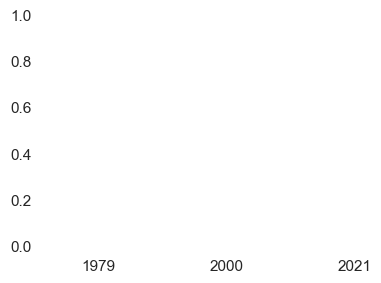

In [13]:
fig, ax = plot_setup_timeseries()

## To-do: Plot the data
# ax.plot(idx.time, idx)

plt.show()

## 2) Compute statistics for the reanalysis
After defining a regional climate index, make a few diagnostic plots of the region and index. The goal is to get a sense for the climate in the region. E.g., some questions to think about may include:
- what is the mean state in your region and how big are typical fluctuations?
- how big are these fluctuations relative to the seasonal cycle?
- what is the timescale of these fluctuations?
- are fluctuations of your index correlated with larger-scale fluctuations?

To address these questions, some possible diagnostic plots include:
- spatial plots of mean, variance
- line/bar plot of index's seasonal cycle (e.g., showing mean and variance for each month)
- histogram of index anomalies (Does the distribution look normal?)
- power spectral density of the index
- spatial plot showing correlation between your index and data at each gridpoint 

```{admonition} To-do
In your submission, include a few (3-4) diagnostic plots of the climate in your region.
```